In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform

np.random.seed(42)

# Download data from the repo https://github.com/rmcelreath/rethinking/tree/master/data 
howell_raw = "Howell1.csv"
d = pd.read_csv(howell_raw, sep=";")
d2 = d[d['age']>=18]

## A first gaussian model

Before going into linear models, we can propose a simple gaussian model to help understand grid approximation and updating the posterior.

Using the data from the Howell study, we can create a simple gaussian model of Height $H$ from the data:

$$
\begin{aligned}
h_i &\sim N(\mu, \sigma) \\
\mu &\sim N(178,20) \\
\sigma &\sim U(0,50)
\end{aligned}
$$

The above formulation has two parameters, $\mu, \sigma$ to estimate the likelihood function for $h_i$:
* $\mu$ is our prior for the mean, centered at 178cm with a standard deviation of 20. 
* $\sigma$ is our prior for the standard deviation

Below, we'll follow along from p.85 of the textbook to do this grid approximation because we need to see it.

In [2]:
n = 100
mu_list = np.linspace(150,160, n)
sigma_list = np.linspace(7,9, n)
# same as R's expand.grid, we want to cover all combinations of mu and sigma
post = np.meshgrid(mu_list, sigma_list)
post = np.array(post).reshape(2, n*n).T # 10000 x 2
post = pd.DataFrame(post, columns=['mu', 'sigma'])

# Sum Log likelihood
LL = [np.sum(np.log(norm.pdf(d2.height, mu, sigma))) for mu, sigma in zip(post.mu, post.sigma)]   
post["LL"] = LL

# Calculate the posterior as the sum of the log likelihoods for height, mu, and sigma
post["prod"] = post["LL"] + np.log(norm.pdf(post["mu"], 178, 20)) + np.log(uniform.pdf(post["sigma"], 0, 50))
post["prob"] = np.exp(post["prod"] - post["prod"].max())
post.head()

,mu,sigma,LL,prod,prob
0,150.00000,7.0,-1299.030296,-1307.836989,1.962639e-35
1,150.10101,7.0,-1295.731184,-1304.530820,5.354162e-34
2,150.20202,7.0,-1292.505369,-1301.297972,1.357374e-32
3,150.30303,7.0,-1289.352848,-1298.138445,3.197901e-31
4,150.40404,7.0,-1286.273623,-1295.052238,7.001443e-30


The resulting table shows a probability for *every* combination of mu and sigma in the `prob` column, $\Pr(\mu,\sigma | h)$

Visualize the posterior distribution as a heatmap and contour plot:

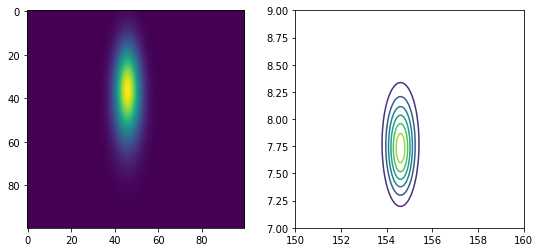

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(post['prob'].values.reshape(100, 100))
ax[1].contour(mu_list, sigma_list, post['prob'].values.reshape(100, 100))

To study this posterior we need to sample parameters from it, just like the globe tossing example where we sampled $p$ from the posterior distribution.

Since there are two parameters, we can sample from a combination of $\mu$ and $\sigma$ from rows in the dataframe (with replacement) and inspect the results

In [4]:
sample_rows = post.sample(10000, weights='prob', replace=True)
sample_mu = sample_rows["mu"]
sample_sigma = sample_rows["sigma"]

We can take a look at the samples:

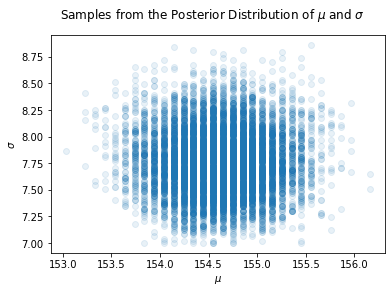

In [5]:
fig, ax = plt.subplots()
ax.scatter(sample_mu, sample_sigma, alpha=0.1)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
fig.suptitle("Samples from the Posterior Distribution of $\mu$ and $\sigma$");

# Example: Generative model in `numpy`

From Statistical Rethinking lecture 03 - Geocentric Models

Let's take the form of a single linear regression:

$$
\begin{aligned}
y &\sim N(\mu, \sigma) \\
\mu &= \alpha + \beta x
\end{aligned}
$$

In the example we will use a linear model, let's say height ($H$) vs weight($W$). Then for a given individual's height $H_i$ we want to model their weight $W_i$. We can specify the model as follows:

$$
\begin{aligned}
W_i &\sim (\mu_i, \sigma) \\
\mu_i &= \alpha + \beta H_i
\end{aligned}
$$

We can generate data following this model with `numpy` with values of $\alpha$, $\beta$, and $\sigma$:

In [6]:
α = 0
β = 0.5
σ = 5
n_individuals = 100

H = np.random.uniform(low=130, high=170, size=n_individuals)

μ = α + β*H
W = np.random.normal(loc=μ, scale=σ, size=n_individuals)

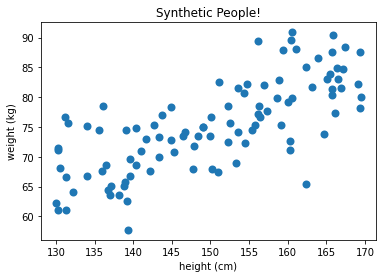

In [7]:
fig, ax = plt.subplots()

ax.scatter(H, W, linewidth=2.0)
ax.set_xlabel('height (cm)')
ax.set_ylabel('weight (kg)')
ax.set_title('Synthetic People!');

of course, in the real world $\alpha$ and $\beta$ are unknown and will need to be estimated.

## Make the linear model statistical

To make it statistical we need to have priors.

We don't know the values of parameters $\alpha$ and $\beta$ so we have to learn them. These $\alpha$'s and $\beta$'s are like the distributions of water in the globe toss example.

### Anatomy of a linear model

$$
\begin{aligned}
y_i &\sim N(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim N(0,1) \\
\beta &\sim N(0,1) \\
\sigma &\sim U(0,1)
\end{aligned}
$$

The three parameters $\alpha$, $\beta$ and $\sigma$ have now become distributions! 

In the lecture, he shows some Animations - lines sampled from this prior distribution. The three bottom lines are the priors and they define a **joint prior distribution**, so now the prior distribution is *full* of lines.

Here's a static example, where we draw sample lines from the joint prior distribution three times:

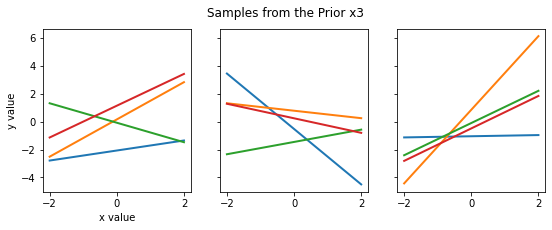

In [8]:
n = 50
x = np.linspace(-2,2, n)

n_samples = 4

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].set_xlabel('x value')
axs[0].set_ylabel('y value')
fig.suptitle('Samples from the Prior x3');

# Sample regression lines from this prior distribution
for j in range(0,3):
    α = np.random.normal(loc=0, scale=1, size=n_samples)
    β = np.random.normal(loc=0, scale=1, size=n_samples)
    for i in range(0,n_samples):
        y = α[i] + β[i]*x
        axs[j].plot(x, y, linewidth=2.0)

We have lines all over the place, and if we took a lot more samples it would just cover the space :)

## Updating the posterior

With bayesian updating, as $n$ increases the lines start to get more concentrated in a smaller space. This is the bayesian goal of learning where the plausible lines are. As n increases, we update the distributions of the three parameters $\alpha, \beta, \sigma$ so that they're no longer $N(0,1)$ (for instance) but instead will get closer to the true distribution as $n$ increases. So then the possible parameters get confined to a tigher space, and the lines that are considered to be more plausible are where the high density of regions are. 

## Statistical model for $H \rightarrow W$

$$
\begin{aligned}
W_i &\sim N(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta(H_i - \bar{H}) \\
\alpha &\sim N(60,10) \\
\beta &\sim \text{LogNormal}(0,1) \\
\sigma &\sim U(0,10)
\end{aligned}
$$

### Sampled Regression Lines

We can sample from the priors on the above model:

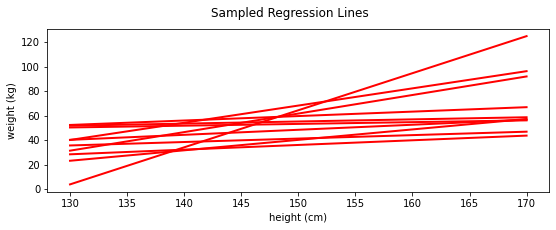

In [9]:
n = 10
α = np.random.normal(loc=60, scale=10, size=n)
β = np.random.lognormal(mean=0, sigma=1, size=n)

Hbar = 150
H = np.linspace(130, 170, 30)

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_xlabel('height (cm)')
ax.set_ylabel('weight (kg)')
fig.suptitle('Sampled Regression Lines');

# Sample regression lines from this prior distribution
for i in range(0, n):
    W = α[i] + β[i]*(H - Hbar)
    ax.plot(H, W, linewidth=2.0, c='red')

### Sermon on Priors

* There are no correct priors, only scientifically justifiable priors
* Justify with information outside the data - *like rest of model*
* Priors not so important in simple linear models
* But need to practice now: simulate, understand, expand

When you get to multilevel models you'll learn the priors from the data itself! The distinctions between priors and data will blur in more advanced models, so we practice priors and their implications now because they'll give us a path to flow forward into more complicated models.

## Fitting the model

$$
\begin{array}{ll} 
W_i \sim N(\mu_i, \sigma)  & \Pr(W_i|\mu_i, \sigma)\\
\mu_i = \alpha + \beta(H_i - \bar{H}) \\
\alpha \sim N(60,10) & \Pr(\alpha) \\
\beta \sim \text{LogNormal}(0,1) & \Pr(\beta)\\
\sigma \sim U(0,10) & \Pr(\sigma) \\
\text{Posterior is } \Pr(\alpha, \beta, \sigma | W, H)
\end{array}
$$

The right side - relative numbers of ways each value can happen. So the top line, the normal distribution gives us the relative ways that the weight can be realized given a mean and standard deviation. 

And then the three probabilities are the priors before we see the data and we update them, and $\mu$ is deterministic.

Then we get a posterior which is the joint prob of *all three* parameters conditioned on the data. There's *only one posterior*, so we get them all at once - **aka the joint distribution of all the parameters**, which considers *all possible combinations* of the parameters $\alpha, \beta, \sigma$, and that's where we do our calculations

So how do you calculate this? When we said that we're looking at all possible values of the three parameters, we're looking at all possible *combinations*.

$$
\begin{aligned}
\Pr(\alpha, \beta, \sigma | W, H) \sim & N(W|\mu, \sigma) \\
& \times N(\alpha | 60, 10) \\
& \times \text{LogNormal}(\beta|0,1) \\
& \times U(\sigma|0,10)
\end{aligned}
$$

And earlier we showed how to do a simple Gaussian model with grid approximation. 

**However:** *Grid approximation* is expensive: For 100 values for each parameter, that's over *1 million* calculations!



## `pymc` with our first gaussian model

Now we leave grid approximation behind and jump right into `pymc` in python and skip the quadratic approximation. 

We'll start by defining the model in `pymc` syntax. Here's the model again:

$$
\begin{aligned}
h_i &\sim \text{Normal}(\mu,\sigma) \\
\mu &\sim \text{Normal}(178, 20) \\
\sigma &\sim \text{Uniform}(0,50)
\end{aligned}
$$

In [10]:
import pymc as pm
import arviz as az

In [11]:
# specify model in `pymc`

model4_1 = pm.Model()

with model4_1:
    mu = pm.Normal("μ", 178, 20)
    sigma = pm.Uniform("σ", 0, 50)
    h = pm.Normal("height", mu=mu, sigma=sigma, observed = d2.height.values)

    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

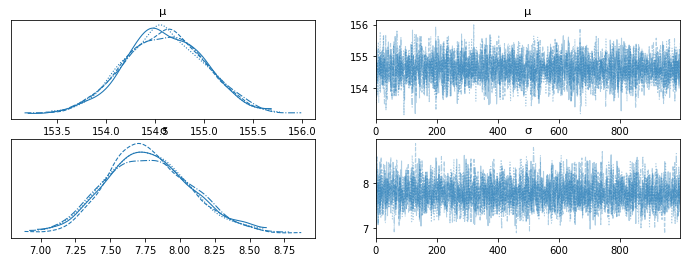

In [12]:
az.plot_trace(trace)

In [13]:
az.summary(trace, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
μ,154.59,0.42,153.80,155.36
σ,7.77,0.30,7.25,8.35


You can use the `initval` parameter (previously `testval`) to provide starting/initial values, otherwise it'll start with a random sample from the prior. In this case we can use the observed mean and standard deviation as a starting point:

In [14]:
model4_1 = pm.Model()

with model4_1:
    mu = pm.Normal("μ", 178, 20, initval=d2.height.mean())
    sigma = pm.Uniform("σ", 0, 50, initval=d2.height.std())
    h = pm.Normal("height", mu=mu, sigma=sigma, observed = d2.height.values)

    trace = pm.sample(1000, tune=1000)
    
az.summary(trace, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%
μ,154.60,0.41,153.84,155.36
σ,7.77,0.30,7.20,8.35


## `pymc` with our linear regression model

Next let's see the linear regression model in `pymc`. We have the option of setting `mu` as a `pm.Deterministic` object, which will output the 

In [18]:
with pm.Model() as model4_3:
    alpha = pm.Normal('α', 178, 100)
    beta = pm.Normal('β', 0, 10)
    sigma = pm.Uniform('σ', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu, sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


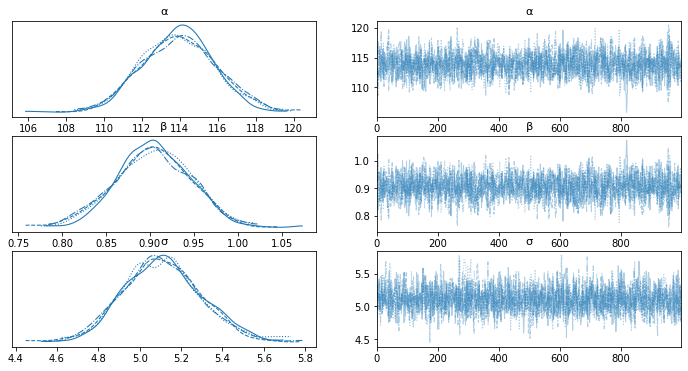

In [22]:
az.plot_trace(trace_4_3);

In [26]:
az.summary(trace_4_3, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,113.93,1.92,110.56,117.74,0.05,0.03,1628.94,1474.61,1.0
β,0.90,0.04,0.82,0.98,0.00,0.00,1666.46,1434.16,1.0
σ,5.11,0.19,4.74,5.45,0.00,0.00,1870.66,1523.87,1.0
